# Binary-Class Image Classification Deep Learning Model for PatchCamelyon Grand Challenge Using TensorFlow Take 5
### David Lowe
### May 13, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The PatchCamelyon Grand Challenge dataset is a binary-class classification situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: The PatchCamelyon benchmark is a new and challenging image classification dataset. It consists of 327680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annotated with a binary label indicating the presence of metastatic tissue. This dataset provides a useful benchmark for machine learning models that are bigger than CIFAR10 but smaller than ImageNet.

In iteration Take1, we constructed a CNN model using a simple three-block VGG architecture and tested the model's performance using a held-out test dataset.

In iteration Take2, we constructed a CNN model using the InceptionV3 architecture and tested the model's performance using a held-out test dataset.

In iteration Take3, we constructed a CNN model using the ResNet50 architecture and tested the model's performance using a held-out test dataset.

In iteration Take4, we constructed a CNN model using the DenseNet121 architecture and tested the model's performance using a held-out test dataset.

In this Take5 iteration, we will construct a CNN model using the MobileNetV3Small architecture and test the model's performance using a held-out test dataset.

ANALYSIS: In iteration Take1, the baseline model's performance achieved an accuracy score of 79.83% on the validation dataset after ten epochs. After we apply the final model to the test dataset, the model achieved an accuracy score of 79.00%.

In iteration Take2, the InceptionV3 model's performance achieved an accuracy score of 83.74% on the validation dataset after ten epochs. After we apply the final model to the test dataset, the model achieved an accuracy score of 79.00%.

In iteration Take3, the ResNet50 model's performance achieved an accuracy score of 85.09% on the validation dataset after ten epochs. After we apply the final model to the test dataset, the model achieved an accuracy score of 78.05%.

In iteration Take4, the DenseNet121 model's performance achieved an accuracy score of 85.62% on the validation dataset after ten epochs. After we apply the final model to the test dataset, the model achieved an accuracy score of 80.01%.

In this Take5 iteration, the MobileNetV3Small model's performance achieved an accuracy score of 82.63% on the validation dataset after ten epochs. After we apply the final model to the test dataset, the model achieved an accuracy score of 78.34%.

CONCLUSION: In this iteration, the MobileNetV3Small CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: PatchCamelyon Grand Challenge

Dataset ML Model: Binary-class image classification with numerical attributes

Dataset Reference: https://patchcamelyon.grand-challenge.org/

A potential source of performance benchmarks: https://patchcamelyon.grand-challenge.org/evaluation/challenge/leaderboard/

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue May  4 19:40:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


## 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 888

In [6]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import zipfile
from datetime import datetime
import h5py
# import boto3
# from dotenv import load_dotenv
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
TEST_SET_SIZE = 0.2
VAL_SET_SIZE = 0.2

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomUniform(seed=seedNum)
CLASSIFIER_ACTIVATION = 'sigmoid'
MAX_EPOCH = 10
BATCH_SIZE = 128
RAW_IMAGE_SIZE = (96, 96)
TARGET_IMAGE_SIZE = (96, 96)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

NUM_CLASSES = 1
CLASS_LABELS = ['Uninfected','Parasitized']

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Define the directory locations and file names
TRAIN_DIR = 'staging/'
VALID_DIR = 'staging/'
TEST_DIR = 'staging/'
LABELS_DIR = 'staging/'
TRAIN_META_CSV = 'camelyonpatch_level_2_split_train_meta.csv'
VALID_META_CSV = 'camelyonpatch_level_2_split_valid_meta.csv'
TEST_META_CSV = 'camelyonpatch_level_2_split_test_meta.csv'
TRAIN_DATASET = 'camelyonpatch_level_2_split_train_x.h5'
VALID_DATASET = 'camelyonpatch_level_2_split_valid_x.h5'
TEST_DATASET = 'camelyonpatch_level_2_split_test_x.h5'
TRAIN_LABELS = 'camelyonpatch_level_2_split_train_y.h5'
VALID_LABELS = 'camelyonpatch_level_2_split_valid_y.h5'
TEST_LABELS = 'camelyonpatch_level_2_split_test_y.h5'
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.4.1


In [8]:
# Set up the parent directory location for loading the dotenv files
# Mount Google Drive locally for storing files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# env_path = "/Users/david/PycharmProjects/"
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
if notifyStatus: status_notify('(TensorFlow Binary-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [11]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [12]:
if notifyStatus: status_notify('(TensorFlow Binary-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [13]:
if notifyStatus: status_notify('(TensorFlow Binary-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [14]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/

In [15]:
STAGING_DIR = 'staging/'
!mkdir staging/

In [16]:
!wget -P staging/ https://dainesanalytics.com/datasets/tensorflow-patchcamelyon-grand-challenge/camelyonpatch_level_2_split_train_meta.csv
!wget -P staging/ https://dainesanalytics.com/datasets/tensorflow-patchcamelyon-grand-challenge/camelyonpatch_level_2_split_train_x.h5.gz
!gzip -dv staging/camelyonpatch_level_2_split_train_x.h5.gz
!wget -P staging/ https://dainesanalytics.com/datasets/tensorflow-patchcamelyon-grand-challenge/camelyonpatch_level_2_split_train_y.h5.gz
!gzip -dv staging/camelyonpatch_level_2_split_train_y.h5.gz

--2021-05-04 19:40:16--  https://dainesanalytics.com/datasets/tensorflow-patchcamelyon-grand-challenge/camelyonpatch_level_2_split_train_meta.csv
Resolving dainesanalytics.com (dainesanalytics.com)... 13.227.220.111, 13.227.220.81, 13.227.220.12, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.227.220.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15047830 (14M) [text/csv]
Saving to: ‘staging/camelyonpatch_level_2_split_train_meta.csv’

camelyonpatch_level 100%[===================>]  14.35M  16.9MB/s    in 0.8s    

2021-05-04 19:40:17 (16.9 MB/s) - ‘staging/camelyonpatch_level_2_split_train_meta.csv’ saved [15047830/15047830]

--2021-05-04 19:40:17--  https://dainesanalytics.com/datasets/tensorflow-patchcamelyon-grand-challenge/camelyonpatch_level_2_split_train_x.h5.gz
Resolving dainesanalytics.com (dainesanalytics.com)... 13.227.220.111, 13.227.220.81, 13.227.220.12, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.227.220.1

In [17]:
!wget -P staging/ https://dainesanalytics.com/datasets/tensorflow-patchcamelyon-grand-challenge/camelyonpatch_level_2_split_valid_meta.csv
!wget -P staging/ https://dainesanalytics.com/datasets/tensorflow-patchcamelyon-grand-challenge/camelyonpatch_level_2_split_valid_x.h5.gz
!gzip -dv staging/camelyonpatch_level_2_split_valid_x.h5.gz
!wget -P staging/ https://dainesanalytics.com/datasets/tensorflow-patchcamelyon-grand-challenge/camelyonpatch_level_2_split_valid_y.h5.gz
!gzip -dv staging/camelyonpatch_level_2_split_valid_y.h5.gz

--2021-05-04 19:44:26--  https://dainesanalytics.com/datasets/tensorflow-patchcamelyon-grand-challenge/camelyonpatch_level_2_split_valid_meta.csv
Resolving dainesanalytics.com (dainesanalytics.com)... 13.227.220.30, 13.227.220.12, 13.227.220.111, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.227.220.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1850810 (1.8M) [text/csv]
Saving to: ‘staging/camelyonpatch_level_2_split_valid_meta.csv’

camelyonpatch_level 100%[===================>]   1.76M  --.-KB/s    in 0.1s    

2021-05-04 19:44:27 (12.5 MB/s) - ‘staging/camelyonpatch_level_2_split_valid_meta.csv’ saved [1850810/1850810]

--2021-05-04 19:44:27--  https://dainesanalytics.com/datasets/tensorflow-patchcamelyon-grand-challenge/camelyonpatch_level_2_split_valid_x.h5.gz
Resolving dainesanalytics.com (dainesanalytics.com)... 13.227.220.30, 13.227.220.12, 13.227.220.111, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.227.220.30|:

In [18]:
images_train_hf = h5py.File(TRAIN_DIR+TRAIN_DATASET, 'r')
print(images_train_hf.keys())
images_train = np.array(images_train_hf.get('x'))
images_train_hf.close()
print(images_train.shape)

<KeysViewHDF5 ['x']>
(262144, 96, 96, 3)


In [19]:
labels_train_hf = h5py.File(TRAIN_DIR+TRAIN_LABELS, 'r')
print(labels_train_hf.keys())
labels_train = np.array(labels_train_hf.get('y')).flatten()
labels_train_hf.close()
print(labels_train.shape)

<KeysViewHDF5 ['y']>
(262144,)


In [20]:
images_valid_hf = h5py.File(VALID_DIR+VALID_DATASET, 'r')
print(images_valid_hf.keys())
images_valid = np.array(images_valid_hf.get('x'))
images_valid_hf.close()
print(images_valid.shape)

<KeysViewHDF5 ['x']>
(32768, 96, 96, 3)


In [21]:
labels_valid_hf = h5py.File(VALID_DIR+VALID_LABELS, 'r')
print(labels_valid_hf.keys())
labels_valid = np.array(labels_valid_hf.get('y')).flatten()
labels_valid_hf.close()
print(labels_valid.shape)

<KeysViewHDF5 ['y']>
(32768,)


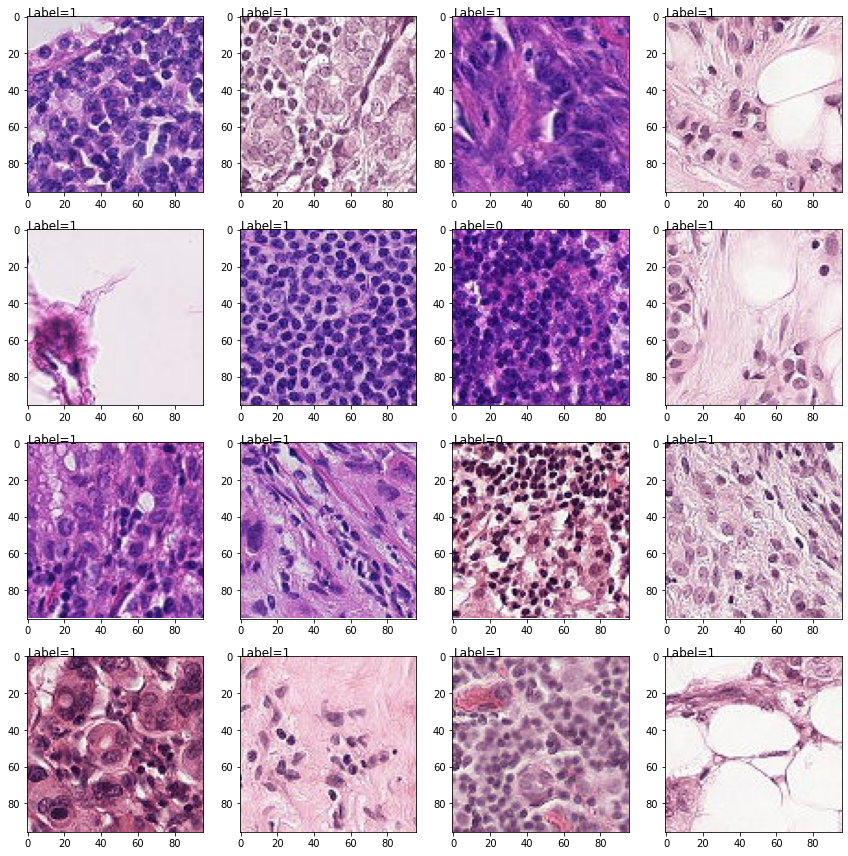

In [22]:
# Spot-checking the first 10 training images
f, ax = plt.subplots(4, 4)
f.set_size_inches(12, 12)
k = 0
for i in range(4):
    for j in range(4):
        ax[i, j].text(0, 0, 'Label='+str(labels_valid[k]), fontsize='large')
        ax[i, j].imshow(images_train[k].reshape(INPUT_IMAGE_SHAPE))
        k += 1
plt.tight_layout()
plt.show()

In [23]:
if notifyStatus: status_notify('(TensorFlow Binary-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [24]:
if notifyStatus: status_notify('(TensorFlow Binary-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [25]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == train_loss:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0.5, 1.1])
        plt.legend()

In [26]:
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, classifier_activation=CLASSIFIER_ACTIVATION,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    base_model = keras.applications.MobileNetV3Small(include_top=False, weights='imagenet', input_shape=input_param, pooling='avg')
    nn_model = keras.models.Sequential()
    nn_model.add(base_model)
    nn_model.add(keras.layers.Flatten())
    # nn_model.add(keras.layers.Dropout(0.25))
    nn_model.add(keras.layers.Dense(output_param, activation=classifier_activation))
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [27]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1, factor=0.5, min_lr=0.000001)
reset_random(seedNum)
baseline_model = create_nn_model()
baseline_model_history = baseline_model.fit(
    images_train, labels_train,
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCH,
	validation_data=(images_valid, labels_valid),
    callbacks=[learning_rate_reduction],
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

6701056/6698480 [==============================] - 0s 0us/step
Epoch 1/10
2048/2048 [==============================] - 89s 33ms/step - loss: 0.3350 - accuracy: 0.8515 - val_loss: 0.5057 - val_accuracy: 0.7975
Epoch 2/10
2048/2048 [==============================] - 65s 32ms/step - loss: 0.1676 - accuracy: 0.9358 - val_loss: 0.4102 - val_accuracy: 0.8457
Epoch 3/10
2048/2048 [==============================] - 64s 31ms/step - loss: 0.1220 - accuracy: 0.9546 - val_loss: 0.5453 - val_accuracy: 0.8252
Epoch 4/10
2048/2048 [==============================] - 65s 32ms/step - loss: 0.0924 - accuracy: 0.9657 - val_loss: 0.4379 - val_accuracy: 0.8589
Epoch 5/10
2048/2048 [==============================] - 66s 32ms/step - loss: 0.0695 - accuracy: 0.9747 - val_loss: 0.4862 - val_accuracy: 0.8572
Epoch 6/10
2048/2048 [==============================] - 66s 32ms/step - loss: 0.0526 - accuracy: 0.9808 - val_loss: 0.6366 - val_accuracy: 0.8393
Epoch 7/10
2048/2048 [==============================] - 65s 3

In [28]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3small (Functional (None, 1024)              1529968   
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 1,530,993
Trainable params: 1,518,881
Non-trainable params: 12,112
_________________________________________________________________


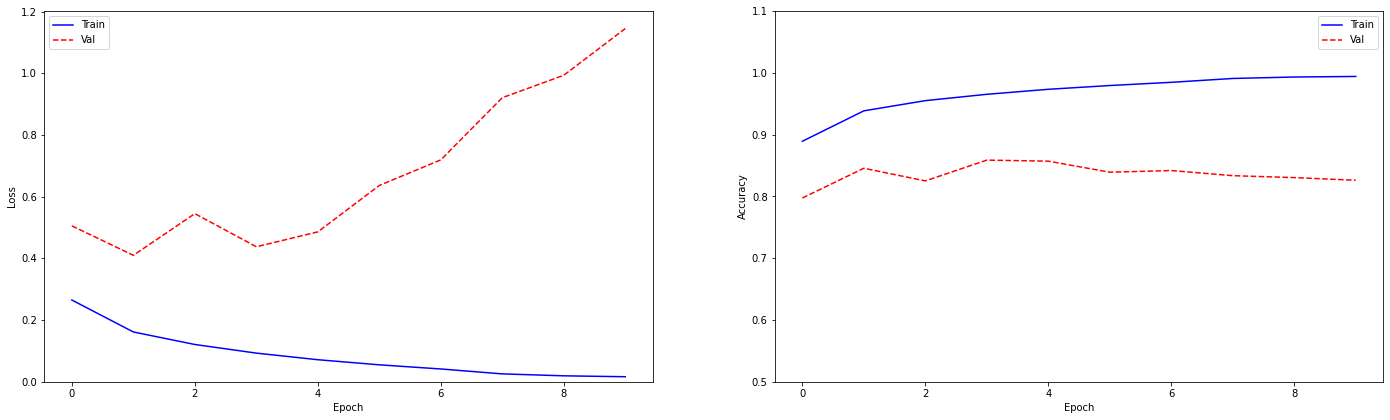

In [29]:
plot_metrics(baseline_model_history)

In [30]:
if notifyStatus: status_notify('(TensorFlow Binary-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [31]:
if notifyStatus: status_notify('(TensorFlow Binary-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [32]:
# Not applicable for this iteration of modeling

In [33]:
if notifyStatus: status_notify('(TensorFlow Binary-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [34]:
if notifyStatus: status_notify('(TensorFlow Binary-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [35]:
!wget -P staging/ https://dainesanalytics.com/datasets/tensorflow-patchcamelyon-grand-challenge/camelyonpatch_level_2_split_test_meta.csv
!wget -P staging/ https://dainesanalytics.com/datasets/tensorflow-patchcamelyon-grand-challenge/camelyonpatch_level_2_split_test_x.h5.gz
!gzip -dv staging/camelyonpatch_level_2_split_test_x.h5.gz
!wget -P staging/ https://dainesanalytics.com/datasets/tensorflow-patchcamelyon-grand-challenge/camelyonpatch_level_2_split_test_y.h5.gz
!gzip -dv staging/camelyonpatch_level_2_split_test_y.h5.gz

--2021-05-04 20:03:42--  https://dainesanalytics.com/datasets/tensorflow-patchcamelyon-grand-challenge/camelyonpatch_level_2_split_test_meta.csv
Resolving dainesanalytics.com (dainesanalytics.com)... 13.227.220.111, 13.227.220.30, 13.227.220.12, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.227.220.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608584 (1.5M) [text/csv]
Saving to: ‘staging/camelyonpatch_level_2_split_test_meta.csv’

camelyonpatch_level 100%[===================>]   1.53M  1.79MB/s    in 0.9s    

2021-05-04 20:03:43 (1.79 MB/s) - ‘staging/camelyonpatch_level_2_split_test_meta.csv’ saved [1608584/1608584]

--2021-05-04 20:03:43--  https://dainesanalytics.com/datasets/tensorflow-patchcamelyon-grand-challenge/camelyonpatch_level_2_split_test_x.h5.gz
Resolving dainesanalytics.com (dainesanalytics.com)... 13.227.220.111, 13.227.220.30, 13.227.220.12, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.227.220.111|:44

In [36]:
images_test_hf = h5py.File(TEST_DIR+TEST_DATASET, 'r')
print(images_test_hf.keys())
images_test = np.array(images_test_hf.get('x'))
images_test_hf.close()
print(images_test.shape)

<KeysViewHDF5 ['x']>
(32768, 96, 96, 3)


In [37]:
labels_test_hf = h5py.File(TEST_DIR+TEST_LABELS, 'r')
print(labels_test_hf.keys())
labels_test = np.array(labels_test_hf.get('y')).flatten()
labels_test_hf.close()
print(labels_test.shape)

<KeysViewHDF5 ['y']>
(32768,)


In [38]:
images_final = np.vstack((images_train, images_valid))
print(images_final.shape)

(294912, 96, 96, 3)


In [39]:
labels_final = np.hstack((labels_train, labels_valid))
print(labels_final.shape)

(294912,)


In [40]:
startTimeModule = datetime.now()
final_LR = 0.000025
FINAL_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=final_LR)
reset_random(seedNum)
final_model = create_nn_model(opt_param=FINAL_OPTIMIZER)
final_model.fit(images_train, labels_train, batch_size=BATCH_SIZE, epochs=MAX_EPOCH, verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/10
2048/2048 [==============================] - 67s 31ms/step - loss: 0.4303 - accuracy: 0.7948
Epoch 2/10
2048/2048 [==============================] - 62s 30ms/step - loss: 0.2586 - accuracy: 0.8937
Epoch 3/10
2048/2048 [==============================] - 63s 31ms/step - loss: 0.2116 - accuracy: 0.9174
Epoch 4/10
2048/2048 [==============================] - 62s 30ms/step - loss: 0.1810 - accuracy: 0.9299
Epoch 5/10
2048/2048 [==============================] - 62s 30ms/step - loss: 0.1577 - accuracy: 0.9392
Epoch 6/10
2048/2048 [==============================] - 62s 30ms/step - loss: 0.1407 - accuracy: 0.9464
Epoch 7/10
2048/2048 [==============================] - 63s 31ms/step - loss: 0.1251 - accuracy: 0.9532
Epoch 8/10
2048/2048 [==============================] - 63s 31ms/step - loss: 0.1151 - accuracy: 0.9577
Epoch 9/10
2048/2048 [==============================] - 63s 31ms/step - loss: 0.1030 - accuracy: 0.9623
Epoch 10/10
2048/2048 [==============================] - 63s 31m

In [41]:
# Display a summary of the final model
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3small (Functional (None, 1024)              1529968   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 1,530,993
Trainable params: 1,518,881
Non-trainable params: 12,112
_________________________________________________________________


In [42]:
final_model.evaluate(images_test, labels_test, verbose=1)

1024/1024 [==============================] - 8s 7ms/step - loss: 0.7041 - accuracy: 0.7835


[0.7041207551956177, 0.783477783203125]

In [43]:
test_pred = final_model.predict(images_test)
test_predictions = (test_pred > 0.5).astype('int').ravel()
print('Accuracy Score:', accuracy_score(labels_test, test_predictions))
print(confusion_matrix(labels_test, test_predictions))
print(classification_report(labels_test, test_predictions))

Accuracy Score: 0.783477783203125
[[15620   771]
 [ 6324 10053]]
              precision    recall  f1-score   support

           0       0.71      0.95      0.81     16391
           1       0.93      0.61      0.74     16377

    accuracy                           0.78     32768
   macro avg       0.82      0.78      0.78     32768
weighted avg       0.82      0.78      0.78     32768



In [44]:
if notifyStatus: status_notify('(TensorFlow Binary-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [45]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:35:17.643852
